In [2]:
# Import basic d3m pipeline modules
from d3m.metadata.pipeline import Pipeline, PrimitiveStep
from d3m.metadata.base import ArgumentType, Context
import importlib
import json
from subprocess import check_output


In [3]:
import d3m.primitives.data_transformation.dataset_to_dataframe
import d3m.primitives.data_transformation.column_parser
import d3m.primitives.data_transformation.construct_predictions
import d3m.primitives.data_transformation.extract_columns_by_semantic_types
import d3m.primitives.data_cleaning.imputer
import d3m.primitives.data_transformation.denormalize
import d3m.primitives.data_preprocessing.text_reader

Create a pipeline using the primitive in the D3M library. 
We will use the OpenML Baseball dataset as a toy example - https://www.openml.org/d/185

In [4]:
# Create pipeline meta file to indicate the training dataset and problem
meta_json = {
            "problem": "185_baseball_problem",
            "full_inputs": ["185_baseball_dataset"],
            "train_inputs": ["185_baseball_dataset_TRAIN"],
            "test_inputs": ["185_baseball_dataset_TEST"],
            "score_inputs": ["185_baseball_dataset_SCORE"]
        }

Create the pipeline object and load the dataset as a D3M Dataframe object (pandas dataframe with added metadata)

In [5]:
pipeline_description = Pipeline(context=Context.TESTING)
pipeline_description.add_input(name='inputs')

# # Step 1: DatasetToDataFrame
step_0 = PrimitiveStep(primitive_description=d3m.primitives.data_transformation.dataset_to_dataframe.Common.metadata.query())
step_0.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='inputs.0')
step_0.add_output('produce')
pipeline_description.add_step(step_0)

__main__: Providing a deprecated argument 'context' to '__init__' function in '<ipython-input-5-64d0b985f924>' at line 1: argument ignored


Parse the columns to extract semantic types 

In [6]:
# Step 2: ColumnParser
step_1 = PrimitiveStep(primitive_description=d3m.primitives.data_transformation.column_parser.DataFrameCommon.metadata.query())
step_1.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.0.produce')
step_1.add_output('produce')
pipeline_description.add_step(step_1)

Data preprocessing, in this case, impute any missing values in our features.

In [7]:
# Step 3: imputer
step_2 = PrimitiveStep(primitive_description=d3m.primitives.data_cleaning.imputer.SKlearn.metadata.query())
step_2.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.1.produce')
step_2.add_hyperparameter(name='use_semantic_types', argument_type=ArgumentType.VALUE,
                          data=True)
step_2.add_hyperparameter(name='return_result', argument_type=ArgumentType.VALUE,
                          data='replace')
step_2.add_output('produce')
pipeline_description.add_step(step_2)

Use Random Forest as our classifier 

In [8]:
# Step 4: Primitive
name_space = "d3m.primitives.classification.random_forest.SKlearn"
import_namespace = ".".join(name_space.split(".")[:-1])
name_space_class = importlib.import_module(import_namespace)

step_3 = PrimitiveStep(primitive_description=name_space_class.SKlearn.metadata.query())
step_3.add_hyperparameter(name='use_semantic_types', argument_type=ArgumentType.VALUE,
                          data=True)
step_3.add_hyperparameter(name='add_index_columns', argument_type=ArgumentType.VALUE,
                          data=True)
step_3.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.2.produce')

step_3.add_argument(name='outputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.2.produce')

step_3.add_output('produce')
pipeline_description.add_step(step_3)

In [9]:
# Step 5: ConstructPredictions
step_4 = PrimitiveStep(
    primitive_description=d3m.primitives.data_transformation.construct_predictions.DataFrameCommon.metadata.query())
step_4.add_argument(name='inputs', argument_type=ArgumentType.CONTAINER, data_reference='steps.3.produce')
step_4.add_argument(name='reference', argument_type=ArgumentType.CONTAINER, data_reference='steps.0.produce')
step_4.add_output('produce')
pipeline_description.add_step(step_4)

In [10]:
# Final Output
pipeline_description.add_output(name='output predictions', data_reference='steps.4.produce')

pipeline_description.to_json_structure()

{'created': '2019-07-18T19:40:14.263054Z',
 'digest': 'ed3d32bf98bbc33606c94d5507286790ac8d24c358190144518bdaddb68a1208',
 'id': '52618f97-6a15-4b08-aef8-e5a38b417ca9',
 'inputs': [{'name': 'inputs'}],
 'outputs': [{'data': 'steps.4.produce', 'name': 'output predictions'}],
 'schema': 'https://metadata.datadrivendiscovery.org/schemas/v0/pipeline.json',
 'steps': [{'arguments': {'inputs': {'data': 'inputs.0', 'type': 'CONTAINER'}},
   'outputs': [{'id': 'produce'}],
   'primitive': {'digest': '3cddf0ce62f0f2d3a5160472a5f6ddc672d5b278ecb13860d1034cafbb701c4f',
    'id': '4b42ce1e-9b98-4a25-b68e-fad13311eb65',
    'name': 'Extract a DataFrame from a Dataset',
    'python_path': 'd3m.primitives.data_transformation.dataset_to_dataframe.Common',
    'version': '0.3.0'},
   'type': 'PRIMITIVE'},
  {'arguments': {'inputs': {'data': 'steps.0.produce', 'type': 'CONTAINER'}},
   'outputs': [{'id': 'produce'}],
   'primitive': {'digest': '43e25a79673fe3b91077f3786bb1b0f6342b5e05f4a69441c10b78cc263

In [17]:
import os
print(os.getcwd())
with open("../pipelines/output_pipelines/pipeline-demo.json", 'w') as fw:
    fw.write(json.dumps(pipeline_description.to_json_structure()))
with open("../pipelines/output_pipelines/pipeline-demo.meta", 'w') as fw:
    fw.write(json.dumps(meta_json))

/Users/shah/Desktop/Development/esip/esip-2019-summer/demo_notebook


In [20]:
"""
Needs datasets locally downloaded and scoring file downloded.
This function is inspired by https://gitlab.com/datadrivendiscovery/common-primitives/blob/8b0c07ef137e6b09ba35e89e0bbd3d1f17f71d27/run_pipelines.sh
"""
file = "../pipelines/output_pipelines/pipeline-demo.meta"
dataset_dir = "../datasets"
scoring_file = "../pipelines/scoring-pipeline/f596cd77-25f8-4d4c-a350-bb30ab1e58f6.yml"
pipeline_dir = "../pipelines/output_pipelines"
pipeline_file = str(file).replace(".meta", ".json")
cmdline_args = ["python",
                "-m",
                "d3m",
                "--pipelines-path",
                pipeline_dir,
                "runtime",
                "--datasets",
                dataset_dir,
                "fit-score",
                "--meta",
                file,
                "--pipeline",
                pipeline_file,
                "--scoring-pipeline",
                scoring_file,
               "--output-run",
                "../pipelines/pipeline_runs/pipeline_runs.yml",
               "--output",
                "predictions.csv"]

check_output(cmdline_args)

b'metric,value,normalized,randomSeed\nF1_MACRO,0.6808243727598565,0.6808243727598565,0\n'

In [21]:
with open("../pipelines/pipeline_runs/pipeline_runs.yml", 'r') as f:
    pipeline_run = f.read()
    print(pipeline_run)

context: TESTING
datasets:
- digest: 2cda12ac8468aff498d6b4473d5f48f83083eabf005f444d6cc3b2579376a9f2
  id: 185_baseball_dataset_TRAIN
end: '2019-07-18T19:45:23.150435Z'
environment:
  engine_version: 0eec929523dbaec9f7ad6f4d6a545843c5e91629
  id: a5c9ccc9-8fba-59d8-bf5c-f36d4e82ff4a
  reference_engine_version: 0eec929523dbaec9f7ad6f4d6a545843c5e91629
  worker_id: 574065ad-8615-547b-b74b-efc0576b486c
id: 8f7e3a14-6e54-5efb-b655-7752f5d3ec7d
pipeline:
  digest: ed3d32bf98bbc33606c94d5507286790ac8d24c358190144518bdaddb68a1208
  id: 52618f97-6a15-4b08-aef8-e5a38b417ca9
problem:
  digest: ee9f35bf2281a29973a989cd71d3f5f1fd85e06c0f2d79226fb148ab74965dc1
  id: 185_baseball_problem
random_seed: 0
run:
  phase: FIT
  results:
    predictions:
      header:
      - d3mIndex
      - Hall_of_Fame
      values:
      - - 0
        - 1
        - 3
        - 4
        - 5
        - 6
        - 7
        - 8
        - 10
        - 11
        - 12
        - 13
        - 16
        - 17
        - 18
  

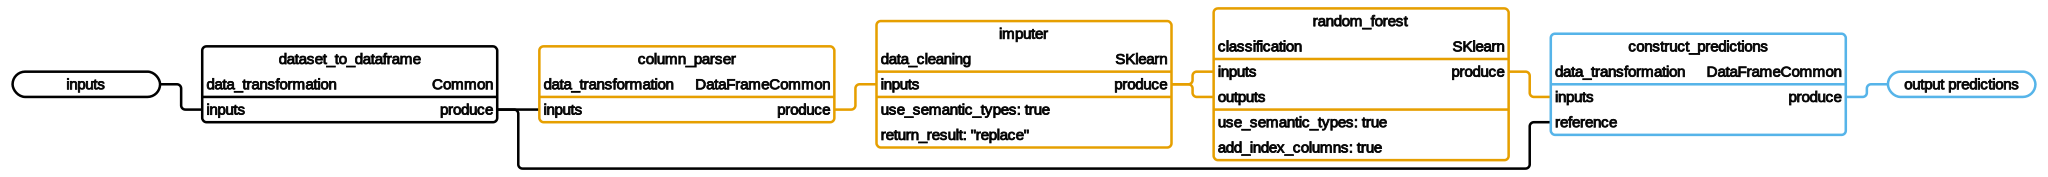

In [28]:
from IPython.display import SVG, display
display(SVG(open("/tmp/pipeline.svg").read()))